In [27]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

# Load

In [2]:
df_train = pd.read_csv('../data/train_clean_v2.csv', parse_dates=['date'], dtype={'fullVisitorId': 'str'})

In [3]:
target = df_train['totals.transactionRevenue'].apply(lambda x: 1 if x > 0 else 0).values
val_cols = [col for col in df_train.columns[2:] if col != 'totals.transactionRevenue']
vals = df_train[val_cols].values
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(vals)

# Funcs

In [4]:
def grid_classifier(model, train, target, parameters={}, cv=4, timed=True, verbose=True, plot=False):
    '''
    For tuning models.
    
    
        Parameters:
        -----------
    model - sklearn model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv results
    plot - boolean, makes a seaborn plot of the cv results, one parameter only
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv)
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    if verbose:
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    
    if plot:
        AUC_means = results['mean_test_score']
        x = range(len(AUC_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(8,6))
        plt.scatter(x=x, y=AUC_means)
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
    
    return gsearcher

In [5]:
def model_validate(model, train, target, cv=5, timed=True, verbose=True, feature_importance=False, feature_cols=None):
    '''
    For validating a model's score on a single set of parameters.
    
        Paramters:
        ----------
    model - sklearn model, parameters set on instantiation
    train - array of training data
    target - array of target data
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    verbose - boolean, printout the cv_results
    feature_importance - boolean, makes a seaborn plot of the feature importance, only works for ensembles
    feature_cols - list of strings, column labels for the feature importance plot, ensemble only
    
        Returns:
        ---------
    model - the fitted sklearn model

    '''
    # Fit and Predict
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    model.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    
    # CV
    cv_score = cross_validation.cross_val_score(model, train, target, cv=cv, scoring='roc_auc')
    if verbose:
        print(f'CV Score : Mean - {np.mean(cv_score):.3f} | Std - {np.std(cv_score):.3f} | Min - {np.min(cv_score):.3f} | Max - {np.max(cv_score):.3f}')
    if timed:
        passed = time() - start
        print(f'Seconds to CV: {passed:.2f}')
    
    # Plots feature importance, for ensemble models only
    if feature_importance:
        feat_imp = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)
    
    return model

In [8]:
def sampler(train, test, size):
    '''
    For quickly sampling out data from an array
    
        Parameters:
        -----------
    train - array, training data
    test - array, target variable
    size - float, 0.0 - 1.0, fraction of data to be returned
    
        Returns:
        --------
    train_sample - array, training data
    test_sample - array, target data
    
    Size: Float, 0.0 - 1.0
        Fraction of data you want returned
    '''
    test_size = 1 - size
    results = train_test_split(train, test, test_size=test_size, random_state=42)
    return results[0], results[2]

---
# Modeling

---
## Naive Bayes

In [5]:
gaussian_gSearch = grid_classifier(GaussianNB(), scaled_vals, target)

Seconds to start: 0.00
Seconds to fit: 3.65
Grid Scores: 

{'mean_fit_time': array([1.07766914]),
 'mean_score_time': array([0.28265524]),
 'mean_test_score': array([0.95811438]),
 'mean_train_score': array([0.95815123]),
 'params': [{}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.95865279]),
 'split0_train_score': array([0.95789989]),
 'split1_test_score': array([0.95655758]),
 'split1_train_score': array([0.95789333]),
 'split2_test_score': array([0.95974835]),
 'split2_train_score': array([0.95860401]),
 'split3_test_score': array([0.95749879]),
 'split3_train_score': array([0.95820768]),
 'std_fit_time': array([0.13831474]),
 'std_score_time': array([0.00886132]),
 'std_test_score': array([0.00120024]),
 'std_train_score': array([0.00029064])}
Best Model Parameters: {}
Best Model Score: 0.9581


---
## Logistic Regression

In [15]:
np.logspace(-6, 3, 10)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03])

Seconds to start: 0.00
Seconds to fit: 75.17
Grid Scores: 

{'mean_fit_time': array([ 3.13209921,  3.4822228 ,  3.89718193,  4.60008883,  5.76942825,
        7.14954364,  8.62375522,  9.78251827, 10.88093817, 10.19381177]),
 'mean_score_time': array([0.09875947, 0.09147102, 0.08179951, 0.10246295, 0.09550333,
       0.08981913, 0.0955348 , 0.09674627, 0.12257266, 0.07908851]),
 'mean_test_score': array([0.9793816 , 0.97985762, 0.97964052, 0.97759402, 0.97480417,
       0.97331314, 0.97297622, 0.97292397, 0.97291829, 0.97291767]),
 'mean_train_score': array([0.97930112, 0.97984342, 0.97965541, 0.97765941, 0.97489092,
       0.9734085 , 0.97307057, 0.97301968, 0.97301529, 0.97301461]),
 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                   100.0, 1000.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 1e-06},
     

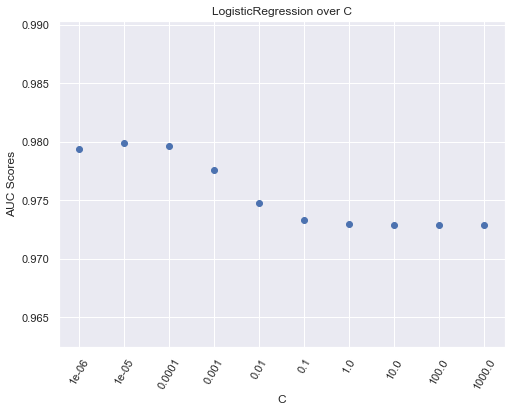

In [16]:
parameters = {
    'C': np.logspace(-6, 3, 10)
}
logReg_gSearch = grid_classifier(LogisticRegression(), scaled_vals, target, parameters=parameters, plot=True)

In [37]:
model = LogisticRegression(C=10**-5)
model = model_validate(model, scaled_vals, target)

Seconds to start: 0.00
Seconds to fit: 1.30
CV Score : Mean - 0.980 | Std - 0.001 | Min - 0.979 | Max - 0.981
Seconds to CV: 7.40


---
## KNN

Seconds to start: 0.00
Seconds to fit: 177.16
Grid Scores: 

{'mean_fit_time': array([0.56976199, 0.57061303, 0.68622267, 0.57605946, 0.44622552,
       0.47847652, 0.43868846, 0.61318356, 0.43313998, 0.44036591,
       0.41111094, 0.40646881, 0.40628898, 0.45924568, 0.39099848,
       0.731188  , 0.52033252]),
 'mean_score_time': array([1.55520505, 1.32392049, 1.66880435, 2.04419494, 1.76066041,
       2.14638376, 1.97914463, 2.53953946, 2.09142631, 2.26546246,
       2.50129104, 2.64290595, 3.07975227, 2.74733102, 3.13126069,
       3.31968182, 3.13595247]),
 'mean_test_score': array([0.96807265, 0.96803835, 0.97181257, 0.97354657, 0.97361843,
       0.97519933, 0.97470897, 0.97443746, 0.9752422 , 0.9763752 ,
       0.97590526, 0.97707582, 0.97665243, 0.97632539, 0.97643848,
       0.97597589, 0.97592608]),
 'mean_train_score': array([0.98338052, 0.98298158, 0.98284108, 0.98259997, 0.98280025,
       0.98267119, 0.98236066, 0.98200749, 0.98158328, 0.98112432,
       0.98052822, 0.979

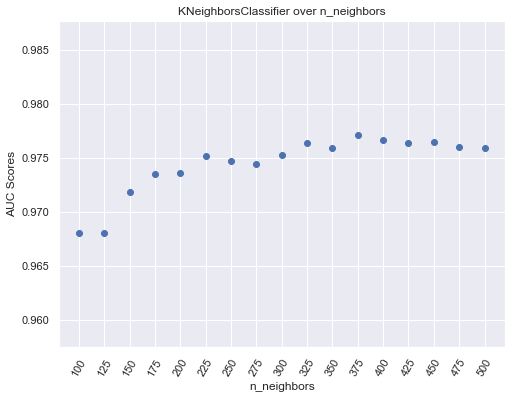

In [30]:
parameters = {
    'n_neighbors': np.arange(100, 501, 25)
}
knn_gSearch = grid_classifier(KNeighborsClassifier(), scaled_vals[:20000], target[:20000], parameters=parameters, plot=True)

In [7]:
model = KNeighborsClassifier(n_neighbors=375)
model = model_validate(model, scaled_vals[:50000], target[:50000])

Seconds to start: 0.00
Seconds to fit: 3.16
CV Score : Mean - 0.980 | Std - 0.005 | Min - 0.971 | Max - 0.989
Seconds to CV: 29.94


In [40]:
model = KNeighborsClassifier(n_neighbors=375)
model = model_validate(model, scaled_vals[:200000], target[:200000])

Seconds to start: 0.00
Seconds to fit: 28.95
CV Score : Mean - 0.981 | Std - 0.001 | Min - 0.980 | Max - 0.983
Seconds to CV: 274.41


Could train on whole dataset and go for an AUC of 0.982 but for now will wait until later (should take 45-60 mins to train locally)

In [7]:
model = KNeighborsClassifier(n_neighbors=375)
model = model_validate(model, scaled_vals[:400000], target[:400000])

Seconds to start: 0.00
Seconds to fit: 151.16
CV Score : Mean - 0.981 | Std - 0.001 | Min - 0.979 | Max - 0.982
Seconds to CV: 8548.20


Timing for the last KNN block is off. I feel satiated with the KNN model and probably won't train on the full dataset.

---
## Random Forest

### Benchmark

Seconds to start: 0.00
Seconds to fit: 4.08
CV Score : Mean - 0.941 | Std - 0.002 | Min - 0.938 | Max - 0.944
Seconds to CV: 23.15


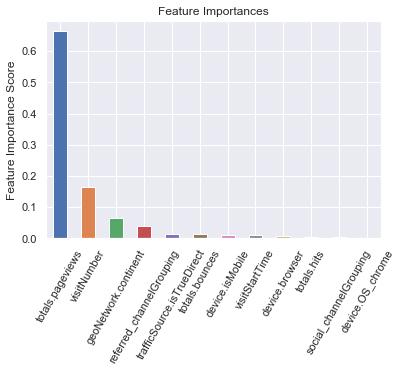

In [15]:
model = RandomForestClassifier(random_state=42)

rf_benchmark_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

### n_estimators

Seconds to start: 0.00
Seconds to fit: 1154.93
Grid Scores: 

{'mean_fit_time': array([ 19.84805602,  35.07819748,  54.56089443,  65.83846653,
        80.51492363,  93.98700678, 115.57871878, 140.10098112,
       151.61695606, 162.84968394]),
 'mean_score_time': array([0.65599412, 1.52764928, 1.73646039, 2.26802874, 2.73406988,
       3.22632426, 3.84231824, 4.41597784, 5.26888424, 5.93583053]),
 'mean_test_score': array([0.94579049, 0.9524357 , 0.95525972, 0.95702655, 0.95814031,
       0.96032049, 0.95991738, 0.96058148, 0.9616747 , 0.96188333]),
 'mean_train_score': array([0.99024918, 0.9903186 , 0.99034111, 0.99034875, 0.99036094,
       0.99036459, 0.99036283, 0.99036703, 0.9903703 , 0.990369  ]),
 'param_n_estimators': masked_array(data=[20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 20},
      

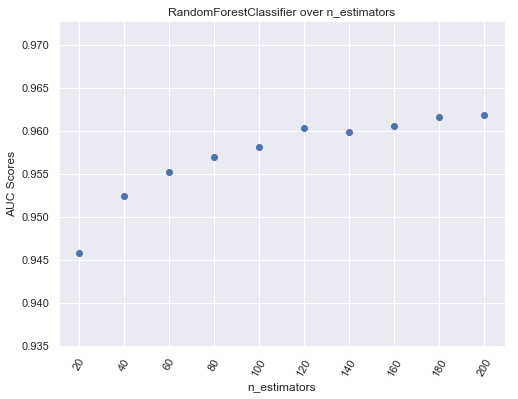

In [35]:
parameters = {'n_estimators': np.arange(20, 201, 20)}

model = RandomForestClassifier(random_state=42)

rf_gSearch = grid_classifier(model, scaled_vals, target, parameters=parameters, plot=True)

Going to stick with 180 to number of trees

### max_depth

Seconds to start: 0.00
Seconds to fit: 1322.61
Grid Scores: 

{'mean_fit_time': array([ 70.62612802,  83.19989932, 105.0445596 , 100.35956115,
       107.81199408, 114.10825878, 119.38622653, 124.48516244,
       131.14557236, 131.95789808]),
 'mean_score_time': array([3.23874778, 3.31476629, 5.30945778, 3.53471452, 3.67314988,
       3.86398429, 3.94780058, 4.0602802 , 4.18571615, 4.27126253]),
 'mean_test_score': array([0.97805017, 0.98033893, 0.98167592, 0.98256398, 0.98329118,
       0.98361914, 0.98408244, 0.98432834, 0.98440859, 0.98423802]),
 'mean_train_score': array([0.97823448, 0.98051389, 0.98188052, 0.98285909, 0.98371399,
       0.98431386, 0.98509735, 0.98578776, 0.98646899, 0.98709828]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 

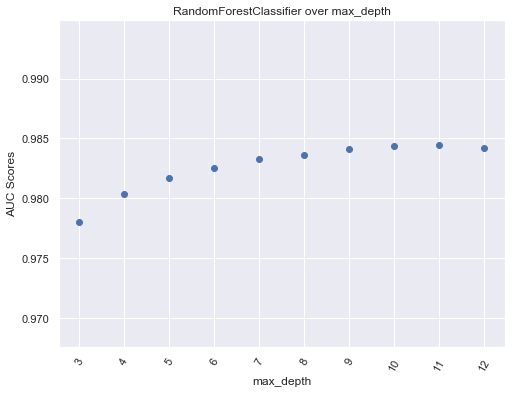

In [7]:
parameters = {'max_depth': range(3, 13)}

model = RandomForestClassifier(
    n_estimators=180,
    random_state=42
)

rf_gSearch = grid_classifier(model, scaled_vals, target, parameters=parameters, plot=True)

10 for max_depth

### min_samples_split

Seconds to start: 0.00
Seconds to fit: 1083.46
Grid Scores: 

{'mean_fit_time': array([125.6563068 , 126.47177619, 127.41305822, 126.04478216,
       133.21837211, 127.56942075, 125.50264406]),
 'mean_score_time': array([4.21033871, 4.06325328, 4.10882652, 4.10454082, 4.09237629,
       4.04762727, 4.18330902]),
 'mean_test_score': array([0.98427142, 0.98430258, 0.9842883 , 0.98424743, 0.98426745,
       0.98416677, 0.9842093 ]),
 'mean_train_score': array([0.9849037 , 0.98489401, 0.98485155, 0.98480402, 0.98478742,
       0.98471802, 0.98469662]),
 'param_min_samples_split': masked_array(data=[700, 800, 900, 1000, 1100, 1200, 1300],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_split': 700},
            {'min_samples_split': 800},
            {'min_samples_split': 900},
            {'min_samples_split': 1000},
            {'min_samples_split': 1100},
            {'min_samples_split': 120

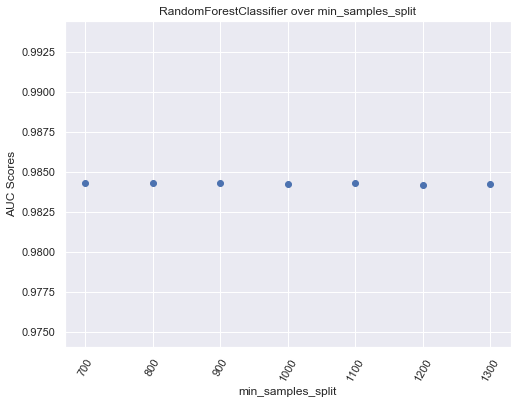

In [8]:
parameters = {'min_samples_split': range(700, 1301, 100)}

model = RandomForestClassifier(
    n_estimators=180,
    max_depth=10,
    random_state=42
)

rf_gSearch = grid_classifier(model, scaled_vals, target, parameters=parameters, plot=True)

Not a lot going on here. Not going to change default value of 1000.

### min_samples_leaf

Seconds to start: 0.00
Seconds to fit: 1578.02
Grid Scores: 

{'mean_fit_time': array([125.36163324, 121.9922846 , 131.31938976, 127.77680665,
       111.722148  , 133.63026047, 150.46261954, 150.33292735,
       139.43566132, 128.58938545]),
 'mean_score_time': array([4.00891393, 4.00023645, 4.06275487, 4.10618269, 3.9677642 ,
       4.37114251, 4.05533355, 5.11102563, 4.13130295, 4.36416429]),
 'mean_test_score': array([0.98422241, 0.98416256, 0.98413883, 0.98405302, 0.98402782,
       0.9839844 , 0.98396621, 0.98390566, 0.98390516, 0.98393166]),
 'mean_train_score': array([0.98477413, 0.98469313, 0.9846644 , 0.98460235, 0.98459091,
       0.98454595, 0.98450523, 0.98447578, 0.98444176, 0.98444795]),
 'param_min_samples_leaf': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_leaf': 5},
      

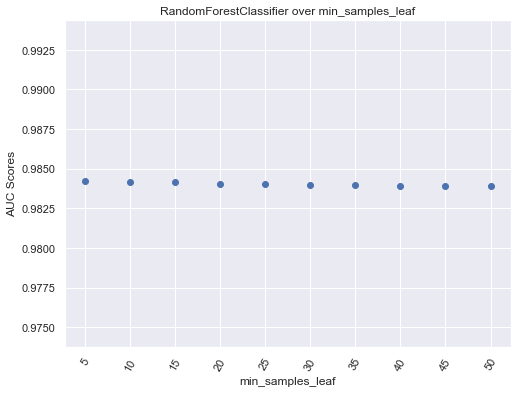

In [11]:
parameters = {
    'min_samples_leaf': range(5, 51, 5)
}

model = RandomForestClassifier(
    n_estimators=180,
    max_depth=10,
    random_state=42
)

rf_gSearch = grid_classifier(model, scaled_vals, target, parameters=parameters, plot=True)

Won't change this either, staying with defualt value of 2.

### max_features

Seconds to start: 0.00
Seconds to fit: 3058.29
Grid Scores: 

{'mean_fit_time': array([ 143.02226573,  163.74121737,  193.68832934,  230.63900459,
       1682.67389816,  344.278763  ]),
 'mean_score_time': array([4.09706193, 4.02067202, 3.99683946, 4.10816348, 4.16257244,
       4.63348979]),
 'mean_test_score': array([0.9845738 , 0.98469147, 0.9846727 , 0.98460429, 0.98454335,
       0.98445055]),
 'mean_train_score': array([0.9860786 , 0.98629112, 0.98647749, 0.9866095 , 0.98671346,
       0.98681335]),
 'param_max_features': masked_array(data=[4, 5, 6, 7, 8, 9],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 4},
            {'max_features': 5},
            {'max_features': 6},
            {'max_features': 7},
            {'max_features': 8},
            {'max_features': 9}],
 'rank_test_score': array([4, 1, 2, 3, 5, 6], dtype=int32),
 'split0_test_score': array([0.98464309, 0.98478525, 0.98

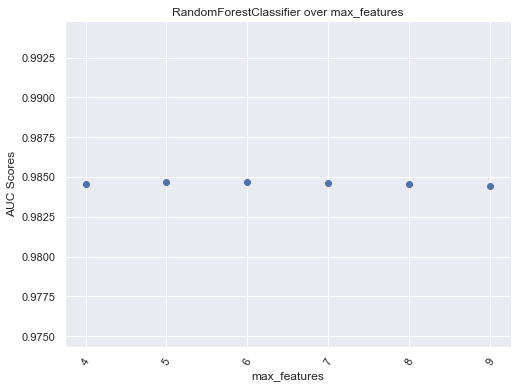

In [12]:
parameters = {
    'max_features': range(4, 10)
}

model = RandomForestClassifier(
    n_estimators=180,
    max_depth=10,
    random_state=42
)

rf_gSearch = grid_classifier(model, scaled_vals, target, parameters=parameters, plot=True)

### Final RFC Model

Seconds to start: 0.00
Seconds to fit: 66.37
CV Score : Mean - 0.984 | Std - 0.001 | Min - 0.983 | Max - 0.985
Seconds to CV: 407.41


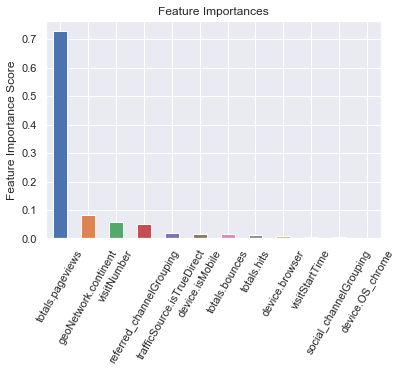

In [16]:
model = RandomForestClassifier(
    n_estimators=180,
    max_depth=10,
    random_state=42
)

rf_final_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

---
## Boosted

### Benchmark

Seconds to start: 0.00
Seconds to fit: 37.86
CV Score : Mean - 0.985 | Std - 0.001 | Min - 0.984 | Max - 0.986
Seconds to CV: 197.22


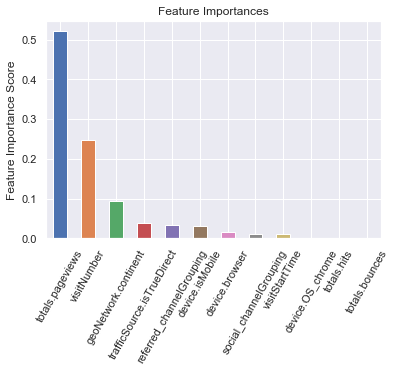

In [7]:
model = XGBClassifier(random_state=42)

xbg_benchmark_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

Dang! Out of the box the XBG Clasifier is outperforming the tuned Random Forest, neat. Going to sample out half of the data for the tuning process and then validate the final model with the complete dataset.

In [9]:
train_sample, target_sample = sampler(scaled_vals, target, 0.5) 

---
### n_estimators

Seconds to start: 0.00
Seconds to fit: 399.16
Grid Scores: 

{'mean_fit_time': array([ 5.67228329, 10.05048496, 12.13887888, 15.34410387, 16.83282959,
       19.29722637, 24.53455532, 28.14894092, 31.00794655, 32.7390362 ,
       36.65233004, 39.91256976, 39.84826803, 42.39740455]),
 'mean_score_time': array([0.09457475, 0.15167695, 0.17006624, 0.15273887, 0.18403322,
       0.20370513, 0.25060678, 0.27032238, 0.36517107, 0.32166976,
       0.37003517, 0.50263554, 0.48496377, 0.36692119]),
 'mean_test_score': array([0.98111348, 0.98174802, 0.98282583, 0.98382793, 0.98392225,
       0.98413753, 0.98443096, 0.9844873 , 0.984633  , 0.98465817,
       0.9846894 , 0.98471033, 0.98471856, 0.98472498]),
 'mean_train_score': array([0.98130312, 0.98194427, 0.98350607, 0.98428738, 0.98441561,
       0.98468847, 0.98490657, 0.98496267, 0.98501725, 0.98506289,
       0.98512416, 0.98517344, 0.98521032, 0.9852446 ]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100, 110

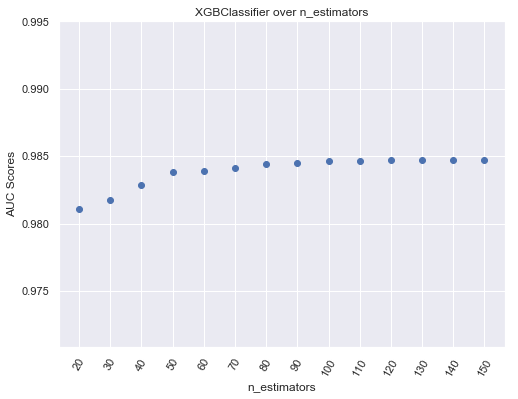

In [14]:
parameters = {'n_estimators': range(20, 151, 10)}

model = XGBClassifier(
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

100 Looks good

---
### max_depth

Seconds to start: 0.00
Seconds to fit: 559.15
Grid Scores: 

{'mean_fit_time': array([29.49622965, 32.25896132, 37.20210767, 50.67291713, 59.61107606,
       64.12157726, 68.91589493, 85.76892859, 79.68661124]),
 'mean_score_time': array([0.31645679, 0.30907601, 0.34872383, 0.40665954, 0.42387068,
       0.41799498, 0.53026813, 0.64141297, 0.56337613]),
 'mean_test_score': array([0.984633  , 0.98463758, 0.98465444, 0.98459873, 0.98450748,
       0.9843563 , 0.98417386, 0.9839472 , 0.9837289 ]),
 'mean_train_score': array([0.98501725, 0.98535486, 0.98570223, 0.98612277, 0.98663242,
       0.98717521, 0.98771937, 0.98814863, 0.98858168]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'

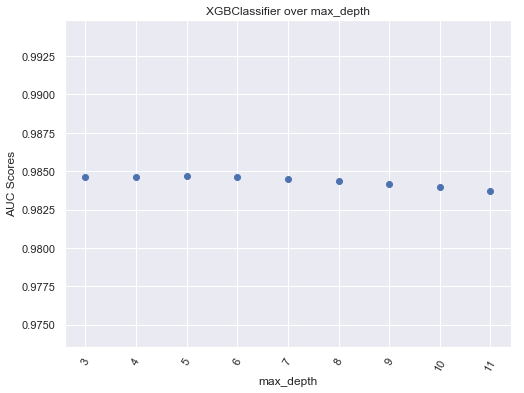

In [15]:
parameters = {'max_depth': range(3, 12)}

model = XGBClassifier(
    n_estimators=100,
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

5 it is

---
### min_child_weight

Seconds to start: 0.00
Seconds to fit: 304.51
Grid Scores: 

{'mean_fit_time': array([42.17459953, 38.21544647, 37.46118224, 36.89158243, 37.33229846,
       36.60629964, 36.64882058]),
 'mean_score_time': array([0.41977257, 0.34105235, 0.32959902, 0.31701183, 0.32340854,
       0.31098801, 0.3079564 ]),
 'mean_test_score': array([0.98465444, 0.98464842, 0.98465433, 0.98469428, 0.98469209,
       0.98467589, 0.98462667]),
 'mean_train_score': array([0.98570223, 0.98567162, 0.98561516, 0.98559433, 0.98555633,
       0.98550709, 0.98545381]),
 'param_min_child_weight': masked_array(data=[1, 2, 3, 4, 5, 6, 7],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_child_weight': 1},
            {'min_child_weight': 2},
            {'min_child_weight': 3},
            {'min_child_weight': 4},
            {'min_child_weight': 5},
            {'min_child_weight': 6},
            {'min_child_weight': 7}],
 'rank

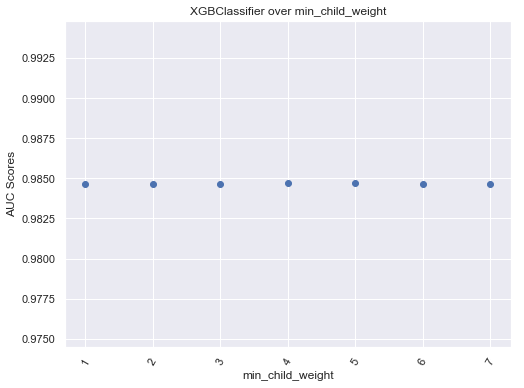

In [16]:
parameters = {'min_child_weight': range(1, 8)}

model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

Sticking with 1, the default value.

---
### gamma

Seconds to start: 0.00
Seconds to fit: 291.04
Grid Scores: 

{'mean_fit_time': array([38.15278482, 38.21435821, 44.96001649, 42.20235503, 48.22384083,
       40.0582239 ]),
 'mean_score_time': array([0.3360014 , 0.32546228, 0.34819072, 0.31963396, 0.37625891,
       0.32675129]),
 'mean_test_score': array([0.98465444, 0.98464585, 0.98465504, 0.98464636, 0.98464249,
       0.98464092]),
 'mean_train_score': array([0.98570223, 0.98570751, 0.98569563, 0.98569321, 0.9856849 ,
       0.98568604]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'gamma': 0.0},
            {'gamma': 0.1},
            {'gamma': 0.2},
            {'gamma': 0.30000000000000004},
            {'gamma': 0.4},
            {'gamma': 0.5}],
 'rank_test_score': array([2, 4, 1, 3, 5, 6], dtype=int32),
 'split0_test_score': array([0.9846444 , 0.98465712, 0.98465321

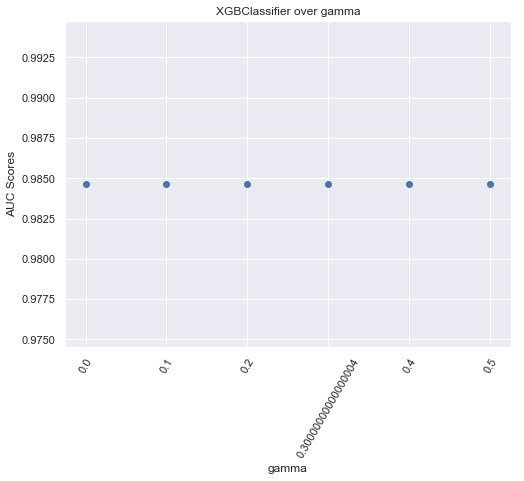

In [17]:
parameters = {'gamma': np.arange(0.0, 0.6, 0.1)}

model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

Sticking with default of 0

---
### subsample

Seconds to start: 0.00
Seconds to fit: 264.93
Grid Scores: 

{'mean_fit_time': array([37.00379556, 36.31903577, 36.61694282, 38.25052512, 37.83343148,
       38.0475629 ]),
 'mean_score_time': array([0.33738416, 0.34543794, 0.3484785 , 0.35385406, 0.34023923,
       0.31919044]),
 'mean_test_score': array([0.98468256, 0.98467754, 0.98467428, 0.98467888, 0.98470164,
       0.98465444]),
 'mean_train_score': array([0.98572923, 0.98575336, 0.98576905, 0.98577189, 0.98575969,
       0.98570223]),
 'param_subsample': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'subsample': 0.5},
            {'subsample': 0.6},
            {'subsample': 0.7},
            {'subsample': 0.8},
            {'subsample': 0.9},
            {'subsample': 1.0}],
 'rank_test_score': array([2, 4, 5, 3, 1, 6], dtype=int32),
 'split0_test_score': array([0.9845807 , 0.9846102 , 0.98463105, 0.

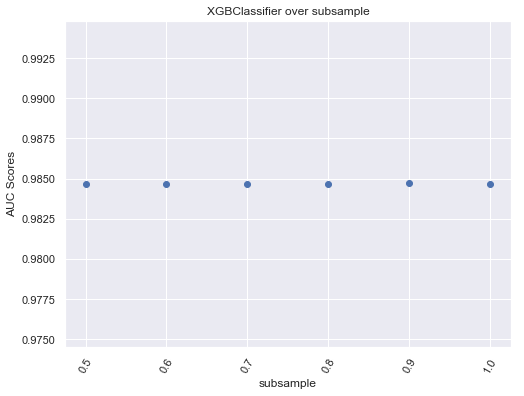

In [18]:
parameters = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

Sticking with 1.0, the default value, because I don't see a reason to make it stochastic

---
### colsample_bytree

Seconds to start: 0.00
Seconds to fit: 217.11
Grid Scores: 

{'mean_fit_time': array([24.55974936, 26.76411754, 28.65909797, 31.98321909, 33.50273758,
       37.20088923]),
 'mean_score_time': array([0.39802223, 0.38043171, 0.37132102, 0.37099808, 0.36117435,
       0.3256669 ]),
 'mean_test_score': array([0.98476494, 0.98476497, 0.98476907, 0.98478546, 0.9847353 ,
       0.98465444]),
 'mean_train_score': array([0.98554153, 0.98562861, 0.98564526, 0.98566364, 0.98567767,
       0.98570223]),
 'param_colsample_bytree': masked_array(data=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'colsample_bytree': 0.5},
            {'colsample_bytree': 0.6},
            {'colsample_bytree': 0.7},
            {'colsample_bytree': 0.8},
            {'colsample_bytree': 0.9},
            {'colsample_bytree': 1.0}],
 'rank_test_score': array([4, 3, 2, 1, 5, 6], dtype=int32),
 'split0_test_scor

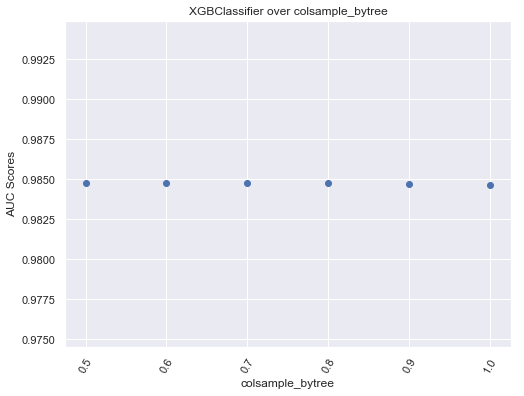

In [19]:
parameters = {'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

xbg_gSearch = grid_classifier(model, train_sample, target_sample, parameters=parameters, plot=True)

Going with 0.8 for this one

---
### learning rate

Starting out with baseline of:

100 Estimators
0.1 Learning Rate (Default)

Seconds to start: 0.00
Seconds to fit: 62.03
CV Score : Mean - 0.985 | Std - 0.001 | Min - 0.984 | Max - 0.986
Seconds to CV: 300.48


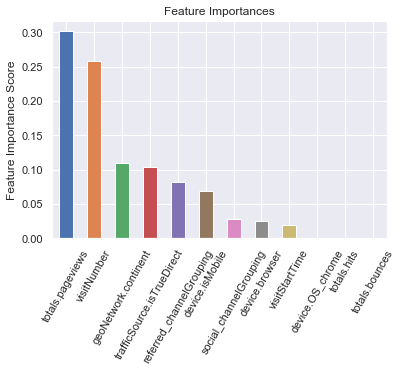

In [21]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    col_sample_bytree=0.8,
    learning_rate=0.1,
    random_state=42
)

xbg_learningRate_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

---
* Estimators:    200
* Learning Rate: 0.05

Timing is higher than actual, interupted processing

Seconds to start: 0.00
Seconds to fit: 110.62
CV Score : Mean - 0.985 | Std - 0.001 | Min - 0.984 | Max - 0.986
Seconds to CV: 1156.01


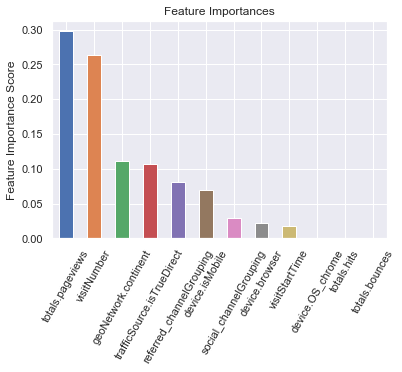

In [23]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    col_sample_bytree=0.8,
    learning_rate=0.05,
    random_state=42
)

xbg_learningRate_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

---
* Estimators:    1000
* Learning Rate: 0.01

Seconds to start: 0.00
Seconds to fit: 555.53
CV Score : Mean - 0.985 | Std - 0.001 | Min - 0.984 | Max - 0.986
Seconds to CV: 2773.20


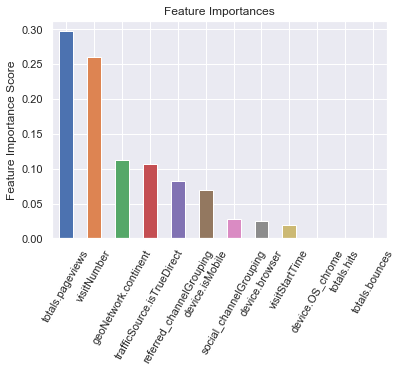

In [24]:
model = XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    col_sample_bytree=0.8,
    learning_rate=0.01,
    random_state=42
)

xbg_learningRate_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

Learning rate seems good. Leaving it with 100/0.01 for the n_estimators/learning_rate

---
### final model

Seconds to start: 0.00
Seconds to fit: 56.37
CV Score : Mean - 0.985 | Std - 0.001 | Min - 0.984 | Max - 0.986
Seconds to CV: 276.89


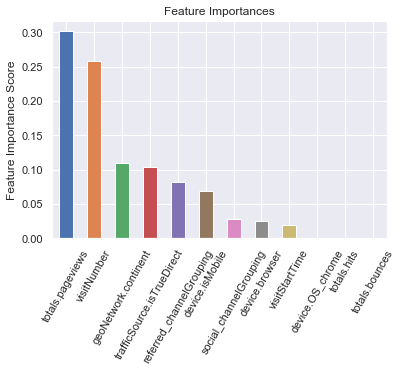

In [26]:
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    col_sample_bytree=0.8,
    random_state=42
)

xbg_final_model = model_validate(model, scaled_vals, target, feature_importance=True, feature_cols=val_cols)

Stick with this for final model. Pickle it for use later

## Pickle

In [30]:
with open('../models/classifier.pkl', 'wb') as pkl:
    pickle.dump(xbg_final_model, pkl)

In [ ]:
with open('classifier.pkl', 'r') as pkl:
    thingy = pickle.dump(pkl)